In [8]:
import numpy as np
import pandas as pd
# For visualizations
import matplotlib.pyplot as plt
# For regular expressions
import re
# For handling string
import string
# For performing mathematical operations
import math

In [19]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.shape

(15000, 10)

In [7]:
train.head()

,ID,comment,date,down,parent_comment,score,top,topic,user,label
0,uid_590555,"Well, let's be honest here, they don't actuall...",2015-04,0,They should shut the fuck up and let the commu...,2,2,starcitizen,Combat_Wombatz,0
1,uid_671762,"Well, I didn't need evidence to believe in com...",2016-12,-1,You need evidence to kill people? I thought we...,6,-1,EnoughCommieSpam,starkadd,1
2,uid_519689,"Who does an ""official promo"" in 360p?",2013-11,0,2014 BMW S1000R: Official Promo,3,3,motorcycles,phybere,0
3,uid_788362,Grotto koth was the best,2015-09,0,Not really that memorable lol if you want memo...,2,2,hcfactions,m0xyMC,1
4,uid_299252,Neal's back baby,2015-11,0,James Neal hit on Zach Parise,-5,-5,hockey,Somuch101,1


### Tensorflow Model Building

In [45]:
# Combining all the text columns into one
train['combined_comment'] = (train['comment'] + " " + train['parent_comment'] + " " + train["topic"] + " " + train['user'])

In [285]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [343]:
# Declaring the parameters
vocab_size = 1000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 12000

In [344]:
# Splitting the training data into training and validation
training_comments = train['combined_comment'][0:training_size]
val_comments = train['combined_comment'][training_size:]

training_labels = train['label'][0:training_size]
val_labels = train['label'][training_size:]

In [345]:
# Tokenizing the text data and converting them into numpy arrays
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_comments)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_comments)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

val_sequences = tokenizer.texts_to_sequences(val_comments)
val_padded = pad_sequences(val_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

val_padded = np.array(val_padded)
val_labels = np.array(val_labels)

In [346]:
# Creating the model
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation='relu'),
    #tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [347]:
model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 100, 16)           16000     
_________________________________________________________________
global_average_pooling1d_30  (None, 16)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_64 (Dense)             (None, 1)                 33        
Total params: 16,577
Trainable params: 16,577
Non-trainable params: 0
_________________________________________________________________


In [348]:
# Running the model for muliple Epochs
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(val_padded, val_labels), verbose=2)

Epoch 1/30
375/375 - 1s - loss: 0.6926 - accuracy: 0.5173 - val_loss: 0.6913 - val_accuracy: 0.5103
Epoch 2/30
375/375 - 1s - loss: 0.6814 - accuracy: 0.5735 - val_loss: 0.6764 - val_accuracy: 0.5490
Epoch 3/30
375/375 - 1s - loss: 0.6489 - accuracy: 0.6263 - val_loss: 0.6603 - val_accuracy: 0.6127
Epoch 4/30
375/375 - 1s - loss: 0.6284 - accuracy: 0.6446 - val_loss: 0.6600 - val_accuracy: 0.6140
Epoch 5/30
375/375 - 1s - loss: 0.6183 - accuracy: 0.6557 - val_loss: 0.6826 - val_accuracy: 0.5970
Epoch 6/30
375/375 - 1s - loss: 0.6135 - accuracy: 0.6628 - val_loss: 0.6630 - val_accuracy: 0.6217
Epoch 7/30
375/375 - 1s - loss: 0.6082 - accuracy: 0.6690 - val_loss: 0.6658 - val_accuracy: 0.6170
Epoch 8/30
375/375 - 1s - loss: 0.6051 - accuracy: 0.6674 - val_loss: 0.6682 - val_accuracy: 0.6140
Epoch 9/30
375/375 - 1s - loss: 0.6022 - accuracy: 0.6712 - val_loss: 0.6784 - val_accuracy: 0.6043
Epoch 10/30
375/375 - 1s - loss: 0.6008 - accuracy: 0.6744 - val_loss: 0.6648 - val_accuracy: 0.6153

In [306]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

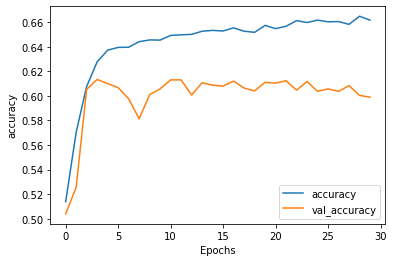

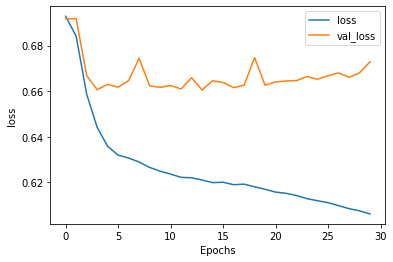

In [324]:
# Checking the validation of the model
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Prediction

In [308]:
test = pd.read_csv('test.csv')

In [309]:
test.head()

,ID,comment,date,down,parent_comment,score,top,topic,user
0,uid_764784,Meanwhile if I pick my boxer up to move him to...,2016-01,0,Part of the Family Fun,2,2,gifs,Cameltoe-Swampdonkey
1,uid_67552,Thats what you get for using an unfair advanta...,2015-03,0,received a warning for hacking while overclock...,1,1,h1z1,Gothika_47
2,uid_240490,only to be later faced with thousands of dolla...,2010-09,0,Running shoes and race entries. I started runn...,1,1,Frugal,tells
3,uid_56568,What a thoughtful rebuttal to a well articulat...,2015-12,0,"Actually, you should get over your self. There...",-1,-1,CFB,YourToothbrush
4,uid_875860,"Yes, major life experiences that demand a grea...",2014-04,0,"As a bonus, it was with his ex, months after t...",-5,-5,AdviceAnimals,drunken_trophy_wife


In [310]:
test['combined_comment'] = (test['comment'] + " " + test['parent_comment'] + " " + test["topic"] + " " + test['user'])

In [311]:
test_comments = test['combined_comment']

test_sequences = tokenizer.texts_to_sequences(test_comments)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [312]:
test_padded = np.array(test_padded)

In [317]:
(model.predict(test_padded))

array([[0.14799026],
       [0.11476177],
       [0.43596643],
       ...,
       [0.26475513],
       [0.43938807],
       [0.5053071 ]], dtype=float32)

In [349]:
test['label_unclean'] = (model.predict(test_padded) > 0.3)

In [350]:
test['label'] = test['label_unclean'].apply(lambda x: 1 if x == True else 0)

In [351]:
test[['ID', 'label']].to_csv('test_label.csv')

In [316]:
test[['ID', 'label']]

,ID,label
0,uid_764784,0
1,uid_67552,0
2,uid_240490,0
3,uid_56568,0
4,uid_875860,0
...,...,...
7995,uid_893847,0
7996,uid_34003,0
7997,uid_921530,0
7998,uid_440748,0
